# Code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

from scipy.special import gamma
from math import sin, pi, sqrt

from numpy.polynomial import Polynomial

from scipy.linalg import cholesky
from scipy.linalg import LinAlgError
from scipy.stats import norm

import seaborn as sns


In [3]:
# Setting up plot parameters
plt.rc('font', family='sans-serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=20, labelsize=20, linewidth=2)
plt.rc('legend', fontsize=16)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('grid', linestyle='-', linewidth=0.5, alpha=0.5)
plt.rc('figure', figsize=(8, 6))

# Using seaborn color palette
plt.style.use('seaborn-colorblind')
# Define your custom color palette
custom_palette = sns.color_palette("colorblind")

# Set the current color palette
sns.set_palette(custom_palette)

# You can also access individual colors from the palette
cur_colors = sns.color_palette()


In [4]:

def sim_waiting_times(D0_mean, D1_mean, n_len, N_trajs, D_levels=[0, 1]):
    levels_waiting_times = np.zeros((n_len, N_trajs), dtype=int)
    for N in range(N_trajs):
        ind = 0  # index of the current time
        state = np.random.choice([0, 1])  # random state 0 or 1
        while ind < n_len:
            if state == 1:
                l = np.ceil(np.random.exponential(D1_mean)).astype(int)
            else:
                l = np.ceil(np.random.exponential(D0_mean)).astype(int)

            levels_waiting_times[ind:min((ind + l), n_len), N] = state
            state = 1 - state  # switch to other state
            ind += l
    return np.array(D_levels)[levels_waiting_times]

# Example usage:
# trajs = sim_waiting_times(D0_mean=3, D1_mean=4, n_len=100, N_trajs=5, D_levels=[0, 1]);

def telegraph_process_stationary_nonsym(n_length, N_trajs, a, b, dt, λ0, λ1):
    return sim_waiting_times(1 / (dt * λ0), 1 / (dt * λ1), n_length, N_trajs, [a, b])
# Example usage:
# trajs = telegraph_process_stationary_nonsym(100, 5, 0, 1, 0.01, 3, 4)


def generalized_telegraph_nonsym(n_length, N_trajs, H0, H1, dt, λ0, λ1, β):
    
    x_process = telegraph_process_stationary_nonsym(n_length, N_trajs, H0, H1, dt, λ0, λ1)

    trajs = np.zeros((n_length, N_trajs))

    u0 = λ0 / β
    u1 = λ1 / β

    X0 = beta.rvs(u0, u1, size=N_trajs)  # beta distribution corresponding to eq. (6) on (0,1) interval

    trajs[0, :] = X0 * (H1 - H0) + H0

    for j in range(n_length - 1):
        trajs[j + 1, :] = trajs[j, :] + dt * β * (x_process[j, :] - trajs[j, :])

    return trajs

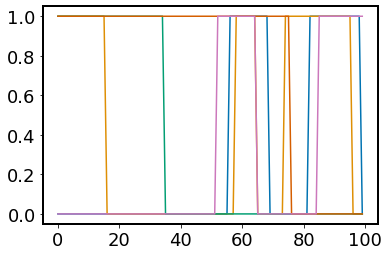

In [5]:
trajs = telegraph_process_stationary_nonsym(100, 5, 0, 1, 0.01, 3, 4)
plt.plot(trajs)

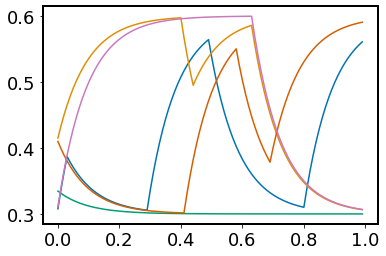

In [6]:
dt = 0.01
n_len, N_trajs = 100, 5
H0, H1 = 0.3, 0.6
lam0, lam1 = 2, 4
b = 10
trajs = generalized_telegraph_nonsym(n_len, N_trajs, H0, H1, dt, lam0, lam1, b)
plt.plot(np.arange(0, dt*n_len, dt), trajs)

In [7]:
def D_mfBm(x, y):
    if 0 <= x <= 1.0 and 0 <= y <= 1.0:
        numerator = sqrt(gamma(2*x + 1) * gamma(2*y + 1) * sin(pi * x) * sin(pi * y))
        denominator = 2 * gamma(x + y + 1) * sin(pi / 2 * (x + y))
        return numerator / denominator
    else:
        raise ValueError("Wrong parameters")
    
def mfBm_acvf_cholesky_from_vector(H, dt):
    n_len = len(H)
    time = np.arange(dt, (n_len + 1) * dt, dt)

    mfBm_cov_matrix = np.zeros((n_len, n_len), dtype=float)

    for k, t in enumerate(time):
        for l, s in enumerate(time):
            mfBm_cov_matrix[k, l] = D_mfBm(H[k], H[l]) * (t**(H[k] + H[l]) + s**(H[k] + H[l]) - abs(t - s)**(H[k] + H[l]))

    try:
        L = cholesky(mfBm_cov_matrix, lower=True)
    except LinAlgError:
        raise ValueError("Cholesky decomposition failed. Matrix may not be positive definite.")

    return L

# Example usage:
# dt = 0.1
# H0, H1 = 0.3, 0.5
# H = generalized_telegraph_nonsym(100, 1, 0.2, 0.5, dt, 5, 10, 10)
# result = mfBm_acvf_cholesky_from_vector(H, dt)
# print(result)

def mfBm_H_from_matrix(H_mat, n_length, N_trajs, dt):
    mfbm = np.zeros((n_length + 1, N_trajs), dtype=float)
    for k in range(H_mat.shape[1]):
        mfBm_cov = mfBm_acvf_cholesky_from_vector(H_mat[:, k], dt)
        mfbm[:, k] = np.concatenate(([0], mfBm_cov @ np.random.normal(size=n_length)))
    return mfbm

def ρFBM(s, t, H, σ=1):
    return σ**2 / 2 * (abs(t)**(2*H) + abs(s)**(2*H) - abs(t - s)**(2*H))

def fBm_cholesky_matrix(N, H, T=None):
    if T is None:
        T = N
    dt = T / N
    Σ = np.array([[ρFBM(row, col, H) for row in np.arange(dt, T + dt, dt)] for col in np.arange(dt, T + dt, dt)])
    return cholesky(Σ, lower=True)

def fBm_cholesky_sim(nLength, nTrajs, H, T=None):
    if T is None:
        T = nLength
    dt = T / nLength
    A = fBm_cholesky_matrix(nLength, H, T)
    return np.column_stack([np.concatenate(([0], (T / nLength)**H * A @ np.random.normal(size=nLength))) for _ in range(nTrajs)])

# Example usage:
# H_mat = np.array([[0.1, 0.2], [0.3, 0.4]])
# n_length = 100
# N_trajs = 10
# dt = 0.1
# result = mfBm_H_from_matrix(H_mat, n_length, N_trajs, dt)
# print(result)


# Estimation

In [8]:
def msd_window(data, window, L_fit, dt=1.0):
    n_length, N_trajs = data.shape
    tamsd_windows = np.zeros((n_length - window, N_trajs, window))
    P = np.zeros((n_length - window, N_trajs, 2))

    time_ = np.arange(dt, (L_fit + 1) * dt, dt)

    for k in range(N_trajs):
        for ind in range(n_length - window):
            for tau in range(1, window + 1):
                tamsd_windows[ind, k, tau - 1] = np.mean((data[(ind + tau):(ind + window), k] - data[ind:(ind + window - tau), k]) ** 2)

            # Perform linear fit on log-log data
            poly_coeffs = np.polyfit(np.log(time_), np.log(tamsd_windows[ind, k, :L_fit]), 1)

            P[ind, k, :] = poly_coeffs

    # Extract estimated parameters
    D_est = np.exp(P[:, :, 1])
    H_est = P[:, :, 0] / 2

    return H_est, D_est, tamsd_windows


# Example 

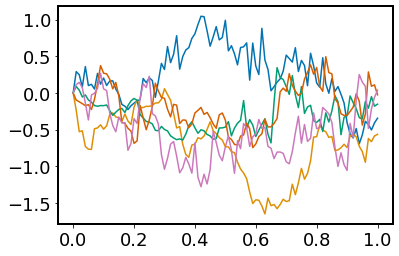

In [9]:
dt = 0.01
n_len, N_trajs = 100, 5
H0, H1 = 0.3, 0.6
lam0, lam1 = 2, 4
b = 10
H = generalized_telegraph_nonsym(n_len, N_trajs, H0, H1, dt, lam0, lam1, b)

trajs = mfBm_H_from_matrix(H, n_len, N_trajs, dt)
plt.plot(np.arange(0, dt*(n_len+1), dt), trajs)

# Simulations

In [29]:
# General parameters
N_trajs = 100
n_len = 2**10
dt = 0.01
time_ = dt * np.arange(n_len + 1)

# Generalized telegraph
λ0 = 1
λ1 = 1.5
β0 = 1 / 3  # τ = 3
β1 = 4      # τ = 0.25

H1 = 0.8
H0 = 0.1

H_fbm = (H0 + H1) / 2

time_ = np.arange(0, (n_len+1)*dt, dt)

In [11]:
g0_approx = generalized_telegraph_nonsym(n_len, N_trajs, H0, H1, dt, λ0, λ1, β0);
mfbm_0 = mfBm_H_from_matrix(g0_approx, n_len, N_trajs, dt);

In [12]:
fbm = fBm_cholesky_sim(n_len, N_trajs, H_fbm, n_len*dt);

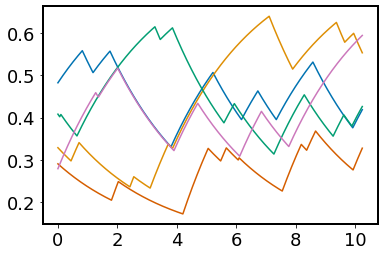

In [59]:
plt.plot(time_[:-1], g0_approx[:, :5])

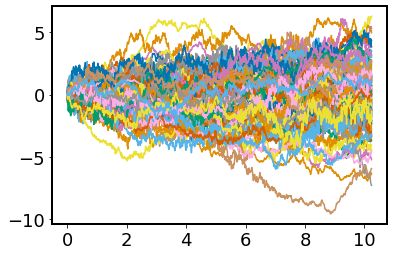

In [13]:
plt.plot(time_, mfbm_0);

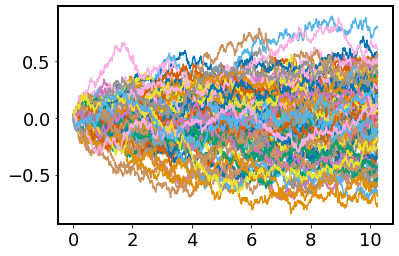

In [14]:
plt.plot(time_, fbm);

# Estimation of local Hurst exponent

In [15]:
window_len = 100
L_fit = 10

In [16]:
H_est, _, _ = msd_window(mfbm_0, window_len, L_fit);


c:\Users\michal\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\michal\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
H_est

array([[0.44697197, 0.30961043, 0.30451588, ..., 0.43972946, 0.5673217 ,
        0.39269366],
       [0.44409572, 0.30609407, 0.30656744, ..., 0.45092404, 0.56946648,
        0.40167485],
       [0.44148433, 0.29536613, 0.30971505, ..., 0.45774034, 0.56766178,
        0.40485834],
       ...,
       [0.43119813, 0.54240312, 0.38765388, ..., 0.48089905, 0.23563054,
        0.43746637],
       [0.42517071, 0.54616609, 0.37888059, ..., 0.4826264 , 0.23852649,
        0.42822275],
       [0.41980596, 0.55043228, 0.3791796 , ..., 0.48351055, 0.25174858,
        0.42407201]])

In [18]:
H_fbm_est, _, _ = msd_window(fbm, window_len, L_fit);


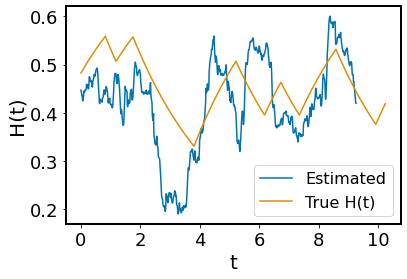

In [33]:
# Assuming H_est and time_ are computed previously
# Assuming g0_approx is the true Hurst exponent computed previously
k_plot = 0
# Plotting the estimated Hurst exponent and the true Hurst exponent
plt.plot(time_[:-window_len], H_est[:, k_plot], label="Estimated")
plt.plot(time_[:-1], g0_approx[:, k_plot], label="True H(t)")

# Adding labels and legend
plt.xlabel('t')
plt.ylabel('H(t)')
plt.legend()

# Show plot
plt.show()

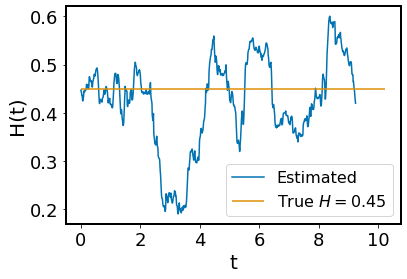

In [39]:
# Assuming H_est and time_ are computed previously
# Assuming g0_approx is the true Hurst exponent computed previously
k_plot = 0
# Plotting the estimated Hurst exponent and the true Hurst exponent
plt.plot(time_[:-window_len], H_est[:, k_plot], label="Estimated")
plt.hlines(H_fbm, time_[0], time_[-1], label=r'True $H = {}$'.format(H_fbm), colors=cur_colors[1])

# Adding labels and legend
plt.xlabel('t')
plt.ylabel('H(t)')
plt.legend()

# Show plot
plt.show()


In [48]:
t_ind = 10 # from where we want to calculate Cov(H(t), H(t+lag))

# time_ = 1:size(data_x, 1)

cov_H = [np.cov(H_est[t_ind,:], H_est[k, :], rowvar=False)[0, 1] for k in range(t_ind, H_est.shape[0])]
cov_H_fbm = [np.cov(H_fbm_est[t_ind,:], H_fbm_est[k, :], rowvar=False)[0, 1] for k in range(t_ind, H_fbm_est.shape[0])]

In [53]:
len(cov_H)
time_[t_ind:(t_ind+len(cov_H)-1-window_len)].shape

(814,)

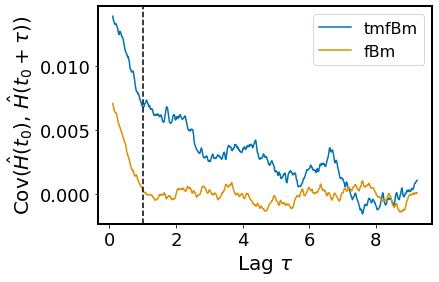

In [56]:
# Plotting the covariance of the estimated Hurst exponent and the true Hurst exponent
plt.plot(time_[t_ind:(-window_len)], cov_H, label="tmfBm")
plt.plot(time_[t_ind:(-window_len)], cov_H_fbm, label="fBm")

# Adding vertical line at the window length
plt.axvline(window_len*dt, color='black', linestyle='--', label=None)

# Adding labels and legend
plt.xlabel(r'Lag $\tau$')
plt.ylabel(r'Cov($\hat{H}(t_0)$, $\hat{H}(t_0 + \tau)$)')
plt.legend()

# Show plot
plt.show()